### BIGRAM LANGUAGE MODEL

In [1]:
import pandas as pd

df = pd.read_csv("./data/updated_rappers.csv")
text = "\n".join(list(df["lyric"]))
df

,Unnamed: 0,artist,song,lyric,next lyric
0,0,Fetty Wap,Trap Queen,rgf productions,remy boyz yahah
1,0,Fetty Wap,Trap Queen,remy boyz yahah,1738 ayy
2,0,Fetty Wap,Trap Queen,1738 ayy,im like hey whats up hello
3,0,Fetty Wap,Trap Queen,im like hey whats up hello,seen yo pretty ass soon as you came in the door
4,0,Fetty Wap,Trap Queen,seen yo pretty ass soon as you came in the door,i just wanna chill got a sack for us to roll
...,...,...,...,...,...
1445296,21096,Das EFX,Gimme Dat Micraphone,dont let me have to transform like optimus prime,cause then ima have to flip the script and get...
1445297,21096,Das EFX,Gimme Dat Micraphone,cause then ima have to flip the script and get...,run laps around your faggot crew like mario an...
1445298,21096,Das EFX,Gimme Dat Micraphone,run laps around your faggot crew like mario an...,when i expand like spandex my jam wrecks the a...
1445299,21096,Das EFX,Gimme Dat Micraphone,when i expand like spandex my jam wrecks the a...,you better be on the way before im doin you an...


In [2]:
## TOKENIZATION FUNCTIONS
charset = sorted(list(set(text)))
slookup = {s: i for i, s in enumerate(charset)}
ilookup = {i: s for i, s in enumerate(charset)}
stoi = lambda x: [slookup[c] for c in x]
itos = lambda x: "".join([ilookup[num] for num in x])

stoi("here")
itos([21, 18, 31, 18])

'here'

In [3]:
## PREPROCESSING TEXT DATASET
import torch
data = torch.tensor(stoi(text), dtype=torch.long)
print("== DATASET SAMPLE ==")
print(data.shape, data.dtype)
print(data[:100])

train_split = 90
split_idx = int(len(data) * (train_split/100))
train_data = data[:split_idx]
val_data = data[split_idx:]

== DATASET SAMPLE ==
torch.Size([56647830]) torch.int64
tensor([31, 20, 19,  2, 29, 31, 28, 17, 34, 16, 33, 22, 28, 27, 32,  1, 31, 18,
        26, 38,  2, 15, 28, 38, 39,  2, 38, 14, 21, 14, 21,  1,  4, 10,  6, 11,
         2, 14, 38, 38,  1, 22, 26,  2, 25, 22, 24, 18,  2, 21, 18, 38,  2, 36,
        21, 14, 33, 32,  2, 34, 29,  2, 21, 18, 25, 25, 28,  2,  1, 32, 18, 18,
        27,  2, 38, 28,  2, 29, 31, 18, 33, 33, 38,  2, 14, 32, 32,  2, 32, 28,
        28, 27,  2, 14, 32,  2, 38, 28, 34,  2])


In [4]:
BATCH_SIZE=4
BLOCK_SIZE=8

def get_batch(split):
    dataset = train_data if split == "train" else val_data 
    # generates n random idxs in the training dataset where n is the batch size
    # generates from 0 to number of tokens in the dataset minus the block size to ensure no index out of bounds errors
    starts = torch.randint(len(dataset) - BLOCK_SIZE, (BATCH_SIZE,))
    # print(starts)
    # print([dataset[start: start + BLOCK_SIZE] for start in starts]) 
    x = torch.stack([dataset[start: start + BLOCK_SIZE] for start in starts])
    y = torch.stack([dataset[start+1: (start+1) + BLOCK_SIZE] for start in starts])

    return x, y

xb, yb = get_batch("train")
for i in range(len(xb)):
    print(itos(xb[i].tolist()))
    print()
    print(itos(yb[i].tolist()))
    print("----")

ease
bit

ase
bitc
----

girls g

girls ga
----
ank acco

nk accou
----
travy ou

ravy out
----


In [5]:
print(len(data))
print(len(set(text)))
vocab_size = len(set(text))

56647830
40


In [6]:
## SIMPLEST NEURAL NETWORK FOR LANGUAGE MODELING
## BIGRAM LANGUAGE MODEL
import torch
import torch.nn as nn
from torch.nn import functional as F

# torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each row is an embedding
        self.embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # logits is in the dimensions (B, T, C)
        # B (batch) is BATCH_SIZE
        # T (time/block size) is BLOCK_SIZE
        # C (channel) is the vocab_size - length of set of all tokens (in this case all characters in our data)
        logits = self.embedding_table(idx)
        # logits are the raw outputs of a randomly initialized model
        # these are the predictions from our input idx for the next character
        # idx is the input which is a batch of n token sequences and embedding_table() will replace each token in each token sequence with the embedding of the next token prediction for all tokens up till that token (inclusive)

        if targets != None:
            # RESIZING (for the cross entropy funciton)
            # pytorch wants the dimensions to be (B, C, T)
            B, T, C = logits.shape
            # (B, T, C) -> (B*T, C)
            logits = logits.view(B*T, C) # dropping batch dimension so now its just a stack of length 40 arrays for all characters in the initial xb mat
            # (B, T) -> (B*T)
            targets = targets.view(B*T)
    
            # LOSS FUNCTION - to measure quality of predictions
            # ENTROPY H(x) = -Σ p(x)log(p(x))
            # CROSS ENTROPY C(x) = -Σ y_c log(p_c) - summed over all classes c: class_label * log(predicted probability of that class)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
        
    def generate(self, idx, max_gen_tokens):
        # idx is a batch of *batch_size* selected token sequences 
        # each iteration a new predicted token will be appended to the end of the token sequence
        # print(idx.shape)
        # print(idx)
        # print("----")
        for _ in range(max_gen_tokens):
            # gets the predictions for each token subsequence in each sequence of the batch token sequences
            # also gets the loss of all predictions
            logits, loss = self(idx)

            # now we need to pluck out the last term in the token sequence to use for next token prediction generation
            # so we essentially for each batch replace each length 8 vector of embeddings in logits with the last embedding in that length 8 vector
            logits = logits[:, -1, :] 
            # print(logits.shape)
            # print(logits)
            # we run softmax on the dimension that contains the last in sequence length 40 vector embeddings we just isolated in the previous step to get the probability distribution to sample from for generating the next predicted token
            probs = F.softmax(logits, dim=-1)
            next_token_index = torch.multinomial(probs, num_samples=1) # now we have a single next token prediction for each vector embedding in each batch
            idx = torch.cat((idx, next_token_index), dim=1)
            # print(idx.shape)
            # print(idx)

        return idx

BLM = BigramLanguageModel(vocab_size)
logits, loss = BLM(xb, yb)
print(f"LOSS {loss}")
print(logits.shape)
print(logits)

LOSS 3.7724997997283936
torch.Size([32, 40])
tensor([[ 0.4064,  0.3521, -0.5285,  ..., -1.0284,  1.5800,  1.5097],
        [-0.3247,  0.3886, -0.4949,  ..., -0.5203,  0.5460,  0.1305],
        [-1.4192,  0.0943, -1.3523,  ..., -0.8468, -0.6703,  1.2105],
        ...,
        [ 0.4875, -1.7064, -2.1134,  ...,  0.1855,  2.8671,  0.4348],
        [ 1.6937,  0.3600,  0.3416,  ..., -0.5112,  0.5251,  0.8031],
        [-1.9528, -1.3383,  1.8093,  ...,  0.7531,  2.3565, -0.7213]],
       grad_fn=<ViewBackward0>)


In [7]:
## TESTING GENERATION
idx = torch.zeros((1, 1), dtype=torch.long)
generated = BLM.generate(idx, 10)
print(generated.shape)
print(itos(generated[0].tolist()))

torch.Size([1, 11])
	oo	o83k yo


In [8]:
## TRAINING
# pytorch optimization object
# the learning rate is kind of high and we can get away with that because the the BigramLanguageModel is a very small network
optimizer = torch.optim.AdamW(BLM.parameters(), lr=1e-3)

## changing batch size from 4 to 32
BATCH_SIZE = 32

elosses = []
losses = []
for epoch in range(10000):
    # gets a batch of training data
    xb, yb = get_batch('train')

    # evaluation, gradient calculation, optimization
    logits, loss = BLM(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"EPOCH {epoch} | LOSS {loss.item()}")
        elosses.append(loss.item())
    losses.append(loss.item())

EPOCH 0 | LOSS 4.12475061416626
EPOCH 100 | LOSS 3.93949556350708
EPOCH 200 | LOSS 3.7314207553863525
EPOCH 300 | LOSS 3.7933692932128906
EPOCH 400 | LOSS 3.729433059692383
EPOCH 500 | LOSS 3.6318516731262207
EPOCH 600 | LOSS 3.4840993881225586
EPOCH 700 | LOSS 3.3650481700897217
EPOCH 800 | LOSS 3.425769567489624
EPOCH 900 | LOSS 3.3558685779571533
EPOCH 1000 | LOSS 3.2787322998046875
EPOCH 1100 | LOSS 3.309098482131958
EPOCH 1200 | LOSS 3.0937459468841553
EPOCH 1300 | LOSS 3.031726598739624
EPOCH 1400 | LOSS 2.9843480587005615
EPOCH 1500 | LOSS 2.920161724090576
EPOCH 1600 | LOSS 2.8104605674743652
EPOCH 1700 | LOSS 2.925705671310425
EPOCH 1800 | LOSS 2.7500736713409424
EPOCH 1900 | LOSS 2.774716854095459
EPOCH 2000 | LOSS 2.7635817527770996
EPOCH 2100 | LOSS 2.833653450012207
EPOCH 2200 | LOSS 2.7091481685638428
EPOCH 2300 | LOSS 2.658472776412964
EPOCH 2400 | LOSS 2.7535979747772217
EPOCH 2500 | LOSS 2.7589471340179443
EPOCH 2600 | LOSS 2.6209614276885986
EPOCH 2700 | LOSS 2.647243

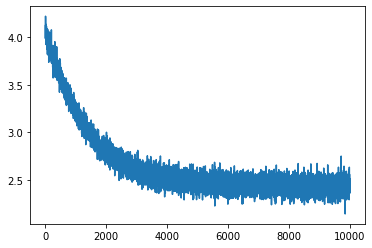

In [9]:
import matplotlib.pyplot as plt

plt.plot(losses)

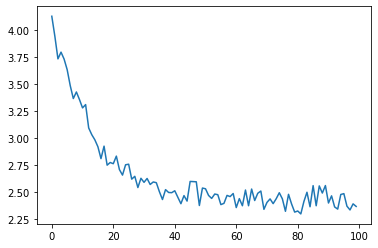

In [10]:
plt.plot(elosses)

In [11]:
# POST TRAINING GENERATION
idx = torch.zeros((1, 1), dtype=torch.long)
generated = BLM.generate(idx, 1000)
print(generated.shape)
print(itos(generated[0].tolist()))

torch.Size([1, 1001])
	7 c9allimyollind m ioheie
y
toromy ilse us nind y cht an ale jurps s un tim g s m iqig bas ghu th q bel indo wes
aha faseat n  bemeryoru ckineyon
y s ts t tin 
fonabood td in
heap fougorlkegeveerdofacesho chen won igouth drohothrkndouni ithe w m far anvealonhig y getome bry ggs p a thuy byoury jur wh y mabe alychubu r it haksy deaticonigann lminncare winonth tr bot te ckimndelirkiflis
lllerffay intackes s the w fig dou s tllis wend
n si vedrihede
s a d ldn t i tdubarthathonde tntrey t tystheranowatheangg ane mersoptimin gowo me
g
iveethhenerl ll tt s inuckneamy t gou
thousst
wes inggeome d in whou wh the ikouca sope shef cri tous man oowi wha lens o ane oup448fu hy ga ositind  bt eyove us kit pesak t r y t ghee d
ye m
h nok lat tck a hleex m h ad
inte l gabarore ontowapede3t gur yowin athtetto bassetat s im mingack
d	at
heme gg yar d cathqu twalitut whhramfes a7_ze ivit
es merdrwyirofoollanonell n in wou neaich hot r st wh y
yootsthe e p be ga ape gxpll t j d mak